In [71]:
from diffprivlib.mechanisms import Laplace as LaplaceMech
from diffprivlib.mechanisms import GaussianAnalytic as GaussianMech
import pickle
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

from dp_policy.titlei.utils import get_saipe, get_sppe
from dp_policy.titlei.bootstrap import Sampled, collect_results

plt.style.use('seaborn-deep')

pd.options.mode.chained_assignment = None

num_bins = 10

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [72]:
NUM_RUNS = 100

saipe = get_saipe("../data/saipe19.xls")
sppe = get_sppe("../data/sppe18.xlsx")

In [73]:

# nonprivate
mech = Sampled(saipe)
results, results_nondp = collect_results(saipe, mech, sppe, num_runs=NUM_RUNS)
with open('../results/bootstrap/results_nondp.pkl', 'wb') as handle:
    pickle.dump(results_nondp, handle)
results.to_csv('../results/bootstrap/results_nondp.csv')

  0%|          | 0/100 [00:00<?, ?it/s]

In [82]:
delta = 1e-6
for epsilon in [0.01, 2.52]:
    # Laplace
    mech = Sampled(saipe, mechanism=LaplaceMech, epsilon=epsilon, delta=delta)
    results, results_laplace = collect_results(saipe, mech, sppe, num_runs=NUM_RUNS)
    print(len(results))
    with open('../results/bootstrap/results_laplace_eps={}.pkl'.format(epsilon), 'wb') as handle:
        pickle.dump(results_laplace, handle)
    results.to_csv('../results/bootstrap/results_laplace_eps={}.csv'.format(epsilon))

    # Gaussian
    mech = Sampled(saipe, mechanism=GaussianMech, epsilon=epsilon, delta=delta)
    results, results_gaussian = collect_results(saipe, mech, sppe, num_runs=NUM_RUNS)
    print(len(results))
    with open('../results/bootstrap/results_gaussian_eps={}.pkl'.format(epsilon), 'wb') as handle:
        pickle.dump(results_gaussian, handle)
    results.to_csv('../results/bootstrap/results_gaussian_eps={}.csv'.format(epsilon))

  0%|          | 0/100 [00:00<?, ?it/s]

1318200


  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [83]:
col_grant = "basic" # choices: basic, targeted, concentration, total
epsilon = 0.01

In [84]:
with open("../results/bootstrap/results_nondp.pkl", 'rb') as handle:
    results_sampling = pickle.load(handle)
df_sampling = pd.read_csv("../results/bootstrap/results_nondp.csv")

path_laplace = "../results/bootstrap/results_laplace_eps={}.pkl".format(epsilon)
with open(path_laplace, 'rb') as handle:
    results_laplace = pickle.load(handle)
df_laplace = pd.read_csv("../results/bootstrap/results_laplace_eps={}.csv".format(epsilon))
print(len(df_laplace))

path_gaussian = "../results/bootstrap/results_gaussian_eps={}.pkl".format(epsilon)
with open(path_gaussian, 'rb') as handle:
    results_gaussian = pickle.load(handle)
df_gaussian = pd.read_csv("../results/bootstrap/results_gaussian_eps={}.csv".format(epsilon))

1318200


## Likelihood of being cheated

Want to know: how likely is it that a district is cheated, compared to the "true" prior?

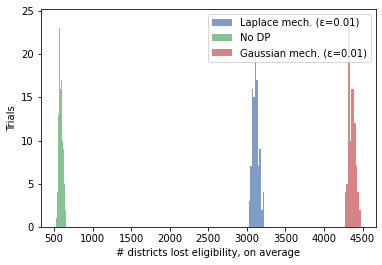

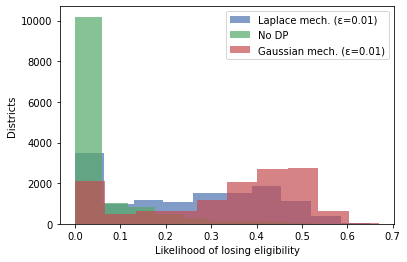

In [87]:
for treatment, df in {
  "Laplace mech. (ε={})".format(epsilon): df_laplace,
  "No DP": df_sampling,
  "Gaussian mech. (ε={})".format(epsilon): df_gaussian
}.items():
  # "cheated" when ineligible but should have been eligible under the prior
  df["lost_eligibility"] = \
    ~df["est_eligible_{}".format(col_grant)] & df["true_eligible_{}".format(col_grant)]
  x = df.groupby('run')["lost_eligibility"].sum()
  plt.hist(x, bins=num_bins, label=treatment, alpha=0.7)

plt.xlabel("# districts lost eligibility, on average")
plt.ylabel("Trials")
plt.legend(loc='upper right')
plt.show()


for treatment, df in {
  "Laplace mech. (ε={})".format(epsilon): df_laplace,
  "No DP": df_sampling,
  "Gaussian mech. (ε={})".format(epsilon): df_gaussian
}.items():
  # "cheated" when ineligible but should have been eligible under the prior
  df["lost_eligibility"] = \
    ~df["est_eligible_{}".format(col_grant)] & df["true_eligible_{}".format(col_grant)]
  x = df.groupby(['State FIPS Code', 'District ID'])["lost_eligibility"].mean()
  plt.hist(x, bins=num_bins, label=treatment, alpha=0.7)

plt.xlabel("Likelihood of losing eligibility")
plt.ylabel("Districts")
plt.legend(loc='upper right')
plt.show()

1318200
1318200
1318200


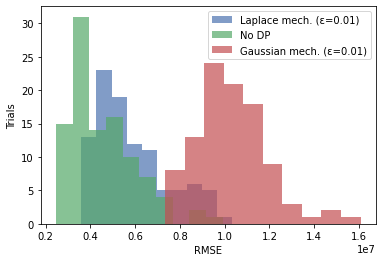

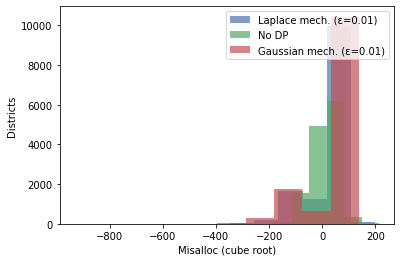

In [108]:
for treatment, df in {
  "Laplace mech. (ε={})".format(epsilon): df_laplace,
  "No DP": df_sampling,
  "Gaussian mech. (ε={})".format(epsilon): df_gaussian
}.items():
  print(len(df))
  # "cheated" when ineligible but should have been eligible under the prior
  df["misalloc"] = df["diff_grant_{}".format('basic')] + \
    df["diff_grant_{}".format('targeted')] + \
    df["diff_grant_{}".format('concentration')]
  df["misalloc_sq"] = np.power(df["misalloc"], 2)
  x = np.sqrt(df.groupby('run')["misalloc_sq"].mean())
  plt.hist(x, bins=num_bins, label=treatment, alpha=0.7)

plt.xlabel("RMSE")
plt.ylabel("Trials")
plt.legend(loc='upper right')
plt.show()

for treatment, df in {
  "Laplace mech. (ε={})".format(epsilon): df_laplace,
  "No DP": df_sampling,
  "Gaussian mech. (ε={})".format(epsilon): df_gaussian
}.items():
  # "cheated" when ineligible but should have been eligible under the prior
  df["misalloc"] = df["diff_grant_{}".format('basic')] + \
    df["diff_grant_{}".format('targeted')] + \
    df["diff_grant_{}".format('concentration')]
  x = df.groupby(['State FIPS Code', 'District ID'])["misalloc"].mean()
  plt.hist(np.sign(x)*np.power(np.abs(x), 1/3), bins=num_bins, label=treatment, alpha=0.7)

plt.xlabel("Misalloc (cube root)")
plt.ylabel("Districts")
plt.legend(loc='upper right')
plt.show()

# Terrance plots

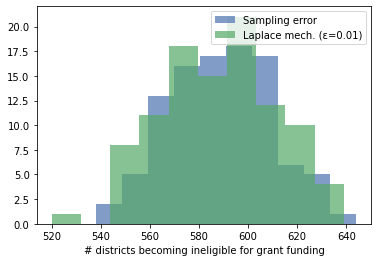

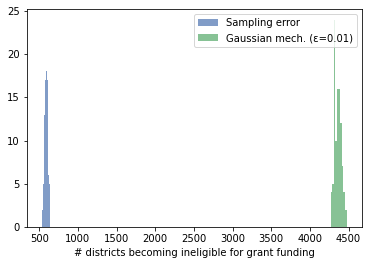

In [14]:
# Number ineligible
quantile = 'sum'
df_sampling = results_sampling[quantile]
df_laplace = results_laplace[quantile]
df_gaussian = results_gaussian[quantile]

x = df_sampling["diff_eligible_{}".format(col_grant)].values
y = df_laplace["diff_eligible_{}".format(col_grant)].values
plt.hist(x, bins=num_bins, label="Sampling error", alpha=0.7)
plt.hist(y, bins=num_bins, label="Laplace mech. (ε={})".format(epsilon), alpha=0.7)
plt.xlabel("# districts becoming ineligible for grant funding")
plt.legend(loc='upper right')
plt.show()

y = df_gaussian["diff_eligible_{}".format(col_grant)].values
plt.hist(x, bins=num_bins, label="Sampling error", alpha=0.7)
plt.hist(y, bins=num_bins, label="Gaussian mech. (ε={})".format(epsilon), alpha=0.7)
plt.xlabel("# districts becoming ineligible for grant funding")
plt.legend(loc='upper right')
plt.show()

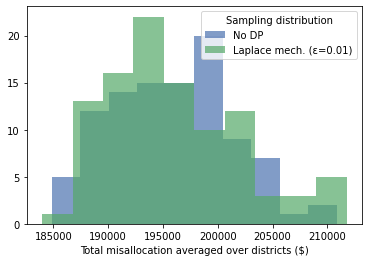

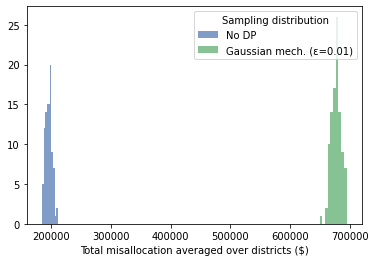

In [38]:
# Average misallocation

quantile = 'mean'
df_sampling = results_sampling[quantile]
df_laplace = results_laplace[quantile]
df_gaussian = results_gaussian[quantile]

x = df_sampling["diff_grant_{}".format(col_grant)].values

y = df_laplace["diff_grant_{}".format(col_grant)].values
plt.hist(x, bins=num_bins, label="No DP", alpha=0.7)
plt.hist(y, bins=num_bins, label="Laplace mech. (ε={})".format(epsilon), alpha=0.7)
plt.xlabel("Total misallocation averaged over districts ($)")
plt.legend(loc='upper right', title="Sampling distribution")
plt.show()

y = df_gaussian["diff_grant_{}".format(col_grant)].values
plt.hist(x, bins=num_bins, label="No DP", alpha=0.7)
plt.hist(y, bins=num_bins, label="Gaussian mech. (ε={})".format(epsilon), alpha=0.7)
plt.xlabel("Total misallocation averaged over districts ($)")
plt.legend(loc='upper right', title="Sampling distribution")
plt.show()

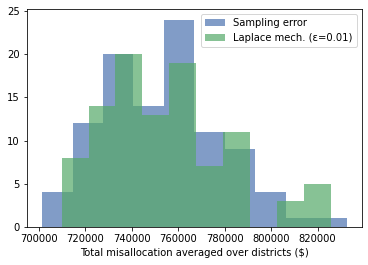

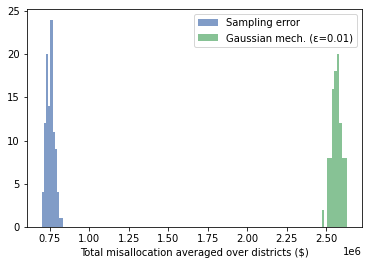

In [39]:
# Average misallocation (sum of all three grant types)
quantile = 'mean'
df_sampling = results_sampling[quantile]
df_laplace = results_laplace[quantile]
df_gaussian = results_gaussian[quantile]

x = df_sampling["diff_grant_{}".format('basic')].values + \
    df_sampling["diff_grant_{}".format('targeted')].values + \
    df_sampling["diff_grant_{}".format('concentration')].values

y = df_laplace["diff_grant_{}".format('basic')].values + \
    df_laplace["diff_grant_{}".format('targeted')].values + \
    df_laplace["diff_grant_{}".format('concentration')].values
plt.hist(x, bins=num_bins, label="Sampling error", alpha=0.7)
plt.hist(y, bins=num_bins, label="Laplace mech. (ε={})".format(epsilon), alpha=0.7)
plt.xlabel("Total misallocation averaged over districts ($)")
plt.legend(loc='upper right')
plt.show()

y = df_gaussian["diff_grant_{}".format('basic')].values + \
    df_gaussian["diff_grant_{}".format('targeted')].values + \
    df_gaussian["diff_grant_{}".format('concentration')].values
plt.hist(x, bins=num_bins, label="Sampling error", alpha=0.7)
plt.hist(y, bins=num_bins, label="Gaussian mech. (ε={})".format(epsilon), alpha=0.7)
plt.xlabel("Total misallocation averaged over districts ($)")
plt.legend(loc='upper right')
plt.show()